# Laboratorio 3 - Agrupación

## 1. Librerias y carga de datos

In [15]:
!pip3 install numpy pandas matplotlib seaborn nltk scikit-learn


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns; sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans # Algoritmo 1
from sklearn.cluster import DBSCAN # Algoritmo 2
from sklearn.cluster import AgglomerativeClustering # Algoritmo 3

from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics

import scipy.stats as stats

In [17]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)


finanzas_inicial = pd.read_csv("./data.csv", sep=";", encoding = "ISO-8859-1")

## 2. Entendimiento de datos

In [18]:
shape=finanzas_inicial.shape
print(shape)
finanzas_inicial.head()

(8950, 18)


,ID,SALDO,F_SALDO,COMPRAS,COMPRAS_PUNTUALES,COMPRAS_PLAZOS,AVANCE_EFECTIVO,F_COMPRAS,F_COMPRAS_PUNTUALES,F_COMPRAS_PLAZOS,F_AVANCE_EFECTIVO,P_AVANCE_EFECTIVO,P_COMPRAS,LÍMITE_CREDITO,PAGOS,PAGOS_MINIMOS,F_PAGOS_COMPLETOS,MESES_CLIENTE
0,C10001,5323.148883,0.250693,26344.07220,38237.442520,3727.113162,15708.239680,0.496536,0.464442,0.821611,0.194502,100,77,16819.48004,21337.027460,39452.95812,0.817907,7
1,C10002,12726.638120,0.791307,37958.51902,5690.742440,18733.810960,38284.354430,0.699457,0.250327,0.654863,1.083902,78,156,15617.57058,8000.183624,63013.74848,0.343119,9
2,C10003,4305.572068,0.176531,28392.95334,36009.470090,2873.383232,14294.185030,0.419764,0.523662,0.899912,0.207049,72,81,15515.58621,27111.360490,NaN,0.829074,6
3,C10004,4740.988511,0.178076,27399.00384,38246.863490,3402.853375,6936.812518,0.439666,0.606597,0.783129,0.228299,78,83,12926.58797,23919.113400,38444.21998,0.883984,7
4,C10005,13820.920640,0.826914,42214.02163,7341.007821,19273.070990,40091.347850,0.821412,0.283579,0.501361,1.106350,88,182,14404.70507,6994.688474,62041.61734,0.383186,10


A partir de esta exploración se puede ver que los datos tienen una dimensión de 18 columnas y 8950 filas. Probablemente algunas de estos valores no aportan valor al objetivo de negocio, por lo que se va a realizar una inspección más profunda para determinar los valores más relevantes para el caso y si vale la pena ignorar alguna de estas columnas

In [19]:
#Copiamos el dataset para no modificar el original
finanzas = finanzas_inicial.copy()
finanzas.dtypes
#Se puede observar que en el dataset hay 17 columnas numericas y 1 columna categorica. La columna categorica es la columna "ID"
#Aunque el ID es numérico, como está acompañado de una C al inicio de cada valor, se toma como categótico

ID                      object
SALDO                  float64
F_SALDO                float64
COMPRAS                float64
COMPRAS_PUNTUALES      float64
COMPRAS_PLAZOS         float64
AVANCE_EFECTIVO        float64
F_COMPRAS              float64
F_COMPRAS_PUNTUALES    float64
F_COMPRAS_PLAZOS       float64
F_AVANCE_EFECTIVO      float64
P_AVANCE_EFECTIVO        int64
P_COMPRAS                int64
LÍMITE_CREDITO         float64
PAGOS                  float64
PAGOS_MINIMOS          float64
F_PAGOS_COMPLETOS      float64
MESES_CLIENTE            int64
dtype: object

Se utiliza el método describe() de Pandas para realizar la descripción de las columnas del DataFrame con los datos. Algunas de las métricas que oobservamos con este método son medidas de tendencia central, medidas de desviación, valor mínimo, etc. Lo único remarcable de los resultados que se observan a continuación es que la mayoría de los parámetros tienen sus filas completas menos algunos. Esto se va a estudiar a profundidad y corregir más adelante. Como es de esperarse, los valores mínimos son 0 para muchos criterios, lo que es conscistente con el contexto del problema

In [20]:
finanzas.describe()

,SALDO,F_SALDO,COMPRAS,COMPRAS_PUNTUALES,COMPRAS_PLAZOS,AVANCE_EFECTIVO,F_COMPRAS,F_COMPRAS_PUNTUALES,F_COMPRAS_PLAZOS,F_AVANCE_EFECTIVO,P_AVANCE_EFECTIVO,P_COMPRAS,LÍMITE_CREDITO,PAGOS,PAGOS_MINIMOS,F_PAGOS_COMPLETOS,MESES_CLIENTE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,9382.387900,0.459205,30525.873439,22913.665720,11407.851805,22573.474202,0.559810,0.478032,0.623916,0.734946,76.169162,164.981453,14696.640361,19824.347218,44222.977795,0.545414,8.370615
std,5118.113559,0.282998,11041.410943,13573.919086,7087.102996,12594.295895,0.214055,0.221873,0.208207,0.422563,22.260935,71.322003,5537.074673,11069.268177,15468.314241,0.267443,1.756035
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,1006.064965,0.000000,6.000000
25%,4275.036859,0.188490,27106.651598,6698.252490,3736.720194,10944.431108,0.407273,0.250856,0.518231,0.230716,65.000000,97.000000,13487.727310,9329.603116,31572.127680,0.336732,7.000000
50%,12007.718810,0.306650,30934.582275,31011.033490,10832.141085,19465.792260,0.505305,0.533521,0.607608,0.947651,82.000000,176.000000,14942.545350,21367.621275,48780.271750,0.432690,8.000000
75%,13740.565878,0.756061,39825.160795,34495.416422,19127.083038,36150.722568,0.777084,0.649120,0.814929,1.029172,92.000000,216.000000,16269.727120,25219.127372,57761.175980,0.815178,10.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


## 3. Limpieza de datos

#### 3.1 Completitud

In [21]:
#Completitud de los datos
(finanzas.isnull().sum() / finanzas.shape[0]).sort_values(ascending = False)

PAGOS_MINIMOS          0.034972
LÍMITE_CREDITO         0.000112
ID                     0.000000
SALDO                  0.000000
F_PAGOS_COMPLETOS      0.000000
PAGOS                  0.000000
P_COMPRAS              0.000000
P_AVANCE_EFECTIVO      0.000000
F_AVANCE_EFECTIVO      0.000000
F_COMPRAS_PLAZOS       0.000000
F_COMPRAS_PUNTUALES    0.000000
F_COMPRAS              0.000000
AVANCE_EFECTIVO        0.000000
COMPRAS_PLAZOS         0.000000
COMPRAS_PUNTUALES      0.000000
COMPRAS                0.000000
F_SALDO                0.000000
MESES_CLIENTE          0.000000
dtype: float64

Se puede ver que la mayoría de los criterios no tiene valores faltantes. Los únicos que si los tienen es PAGOS_MINIMOS y LIMITE_CREDITO, pero son menores a 3,5% y 0,01%. Aunque estaría bien eliminarlos porque no respresentan un gran valor en el conjunto de datos, se decide reemplaarlos por la mediana para evitar distorción de los datos

In [22]:
finanzas["PAGOS_MINIMOS"].fillna(finanzas["PAGOS_MINIMOS"].median(), inplace=True)
finanzas["LÍMITE_CREDITO"].fillna(finanzas["LÍMITE_CREDITO"].median(), inplace=True)
#Se verifica que se hayan reemplazado los valores nulos
(finanzas.isnull().sum() / finanzas.shape[0]).sort_values(ascending = False)

/var/folders/th/n9l6d1r91ys8b_wd6mxk3sh40000gn/T/ipykernel_3878/2680793410.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  finanzas["PAGOS_MINIMOS"].fillna(finanzas["PAGOS_MINIMOS"].median(), inplace=True)
/var/folders/th/n9l6d1r91ys8b_wd6mxk3sh40000gn/T/ipykernel_3878/2680793410.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

ID                     0.0
SALDO                  0.0
F_PAGOS_COMPLETOS      0.0
PAGOS_MINIMOS          0.0
PAGOS                  0.0
LÍMITE_CREDITO         0.0
P_COMPRAS              0.0
P_AVANCE_EFECTIVO      0.0
F_AVANCE_EFECTIVO      0.0
F_COMPRAS_PLAZOS       0.0
F_COMPRAS_PUNTUALES    0.0
F_COMPRAS              0.0
AVANCE_EFECTIVO        0.0
COMPRAS_PLAZOS         0.0
COMPRAS_PUNTUALES      0.0
COMPRAS                0.0
F_SALDO                0.0
MESES_CLIENTE          0.0
dtype: float64

#### 3.2 Duplicidad

In [23]:
#duplicidad

duplicates = finanzas.duplicated()
num_duplicates = duplicates.sum()
print("Numero de duplicados: ", num_duplicates)

Numero de duplicados:  0


Como no hay registros duplicados no se toma ninguna acción

#### 3.3 Consistencia

En este punto se hace una exploración de cada uno de los parámetros para asegurar que cumple con el contexto del problema y los lineamientos del diccionario de datos

In [24]:
#Revisión de negativos
#Solo se toman los siguientes campos para la revisión de negativos porque los otros se van a revisar por rango
#SALDO, COMPRAS, COMPRAS_PUNTUALES, COMPRAS_PLAZOS, AVANCE_EFECTIVO, P_AVANCE_EFECTIVO, P_COMPRAS, LÍMITE_CREDITO, PAGOS, PAGOS_MINIMOS, F_PAGOS_COMPLETOS, MESES_CLIENTE

saldo_negativo = finanzas[finanzas["SALDO"] < 0]
compras_negativo = finanzas[finanzas["COMPRAS"] < 0]
compras_puntuales_negativo = finanzas[finanzas["COMPRAS_PUNTUALES"] < 0]
compras_plazos_negativo = finanzas[finanzas["COMPRAS_PLAZOS"] < 0]
avance_efectivo_negativo = finanzas[finanzas["AVANCE_EFECTIVO"] < 0]
p_avance_efectivo_negativo = finanzas[finanzas["P_AVANCE_EFECTIVO"] < 0]
p_compras_negativo = finanzas[finanzas["P_COMPRAS"] < 0]
limite_credito_negativo = finanzas[finanzas["LÍMITE_CREDITO"] < 0]
pagos_negativo = finanzas[finanzas["PAGOS"] < 0]
pagos_minimos_negativo = finanzas[finanzas["PAGOS_MINIMOS"] < 0]
f_pagos_completos_negativo = finanzas[finanzas["F_PAGOS_COMPLETOS"] < 0]
meses_cliente_negativo = finanzas[finanzas["MESES_CLIENTE"] < 0]

print("Número de saldos negativos: ", saldo_negativo.shape[0])
print("Número de compras negativos: ", compras_negativo.shape[0])
print("Número de compras puntuales negativos: ", compras_puntuales_negativo.shape[0])
print("Número de compras plazos negativos: ", compras_plazos_negativo.shape[0])
print("Número de avance efectivo negativos: ", avance_efectivo_negativo.shape[0])
print("Número de porcentaje avance efectivo negativos: ", p_avance_efectivo_negativo.shape[0])
print("Número de porcentaje compras negativos: ", p_compras_negativo.shape[0])
print("Número de límite de crédito negativos: ", limite_credito_negativo.shape[0])
print("Número de pagos negativos: ", pagos_negativo.shape[0])
print("Número de pagos mínimos negativos: ", pagos_minimos_negativo.shape[0])
print("Número de pagos completos negativos: ", f_pagos_completos_negativo.shape[0])
print("Número de meses cliente negativos: ", meses_cliente_negativo.shape[0])

Número de saldos negativos:  0
Número de compras negativos:  0
Número de compras puntuales negativos:  0
Número de compras plazos negativos:  0
Número de avance efectivo negativos:  0
Número de porcentaje avance efectivo negativos:  0
Número de porcentaje compras negativos:  0
Número de límite de crédito negativos:  0
Número de pagos negativos:  0
Número de pagos mínimos negativos:  0
Número de pagos completos negativos:  0
Número de meses cliente negativos:  0


Se aprecia que ninguna columna de las estudiadas tiene un valor negativo, por lo que no se toma ninguna acción para reemplazar/corregir valores

In [25]:
#Rango de datos
#Se revisan los rangos de los datos para identificar si hay valores atípicos en los siguientes parametros. Todos deberían estar entre 0 y 1
#F_SALDO, F_COMPRAS, F_COMPRAS_PUNTUALES, F_COMPRAS_PLAZOS, F_AVANCE_EFECTIVO, F_PAGOS_COMPLETOS

saldo_rango = finanzas[(finanzas["F_SALDO"] < 0) | (finanzas["F_SALDO"] > 1)]
compras_rango = finanzas[(finanzas["F_COMPRAS"] < 0) | (finanzas["F_COMPRAS"] > 1)]
compras_puntuales_rango = finanzas[(finanzas["F_COMPRAS_PUNTUALES"] < 0) | (finanzas["F_COMPRAS_PUNTUALES"] > 1)]
compras_plazos_rango = finanzas[(finanzas["F_COMPRAS_PLAZOS"] < 0) | (finanzas["F_COMPRAS_PLAZOS"] > 1)]
avance_efectivo_rango = finanzas[(finanzas["F_AVANCE_EFECTIVO"] < 0) | (finanzas["F_AVANCE_EFECTIVO"] > 1)]
f_pagos_completos_rango = finanzas[(finanzas["F_PAGOS_COMPLETOS"] < 0) | (finanzas["F_PAGOS_COMPLETOS"] > 1)]

print("Número de saldos fuera de rango: ", saldo_rango.shape[0])
print("Número de compras fuera de rango: ", compras_rango.shape[0])
print("Número de compras puntuales fuera de rango: ", compras_puntuales_rango.shape[0])
print("Número de compras plazos fuera de rango: ", compras_plazos_rango.shape[0])
print("Número de avance efectivo fuera de rango: ", avance_efectivo_rango.shape[0])
print("Número de pagos completos fuera de rango: ", f_pagos_completos_rango.shape[0])

Número de saldos fuera de rango:  0
Número de compras fuera de rango:  0
Número de compras puntuales fuera de rango:  0
Número de compras plazos fuera de rango:  0
Número de avance efectivo fuera de rango:  3040
Número de pagos completos fuera de rango:  0


Se puede ver que todos los atributos cumplen con su rango exepto la frecuencia de los avances en efectivo (F_AVANCE_EFECTIVO). Como 3040  valores están fuera del rango, esto significa que el 33,96%  (8950 registros totales/3040 fuera de rango) de estos datos no nos está dando información útil y, al contrario, pueden ser perjudiciales para el modelo. Por esto se toma la decisión de eliminar la columna.

In [26]:
finanzas.drop(columns=["F_AVANCE_EFECTIVO"], inplace=True)
#Se vefifica que se haya eliminado la columna
finanzas.head()

,ID,SALDO,F_SALDO,COMPRAS,COMPRAS_PUNTUALES,COMPRAS_PLAZOS,AVANCE_EFECTIVO,F_COMPRAS,F_COMPRAS_PUNTUALES,F_COMPRAS_PLAZOS,P_AVANCE_EFECTIVO,P_COMPRAS,LÍMITE_CREDITO,PAGOS,PAGOS_MINIMOS,F_PAGOS_COMPLETOS,MESES_CLIENTE
0,C10001,5323.148883,0.250693,26344.07220,38237.442520,3727.113162,15708.239680,0.496536,0.464442,0.821611,100,77,16819.48004,21337.027460,39452.95812,0.817907,7
1,C10002,12726.638120,0.791307,37958.51902,5690.742440,18733.810960,38284.354430,0.699457,0.250327,0.654863,78,156,15617.57058,8000.183624,63013.74848,0.343119,9
2,C10003,4305.572068,0.176531,28392.95334,36009.470090,2873.383232,14294.185030,0.419764,0.523662,0.899912,72,81,15515.58621,27111.360490,48780.27175,0.829074,6
3,C10004,4740.988511,0.178076,27399.00384,38246.863490,3402.853375,6936.812518,0.439666,0.606597,0.783129,78,83,12926.58797,23919.113400,38444.21998,0.883984,7
4,C10005,13820.920640,0.826914,42214.02163,7341.007821,19273.070990,40091.347850,0.821412,0.283579,0.501361,88,182,14404.70507,6994.688474,62041.61734,0.383186,10


#### 3.4 Escogencia de atributos y estandarización

>> Se visualizan los datos en conjunto: 


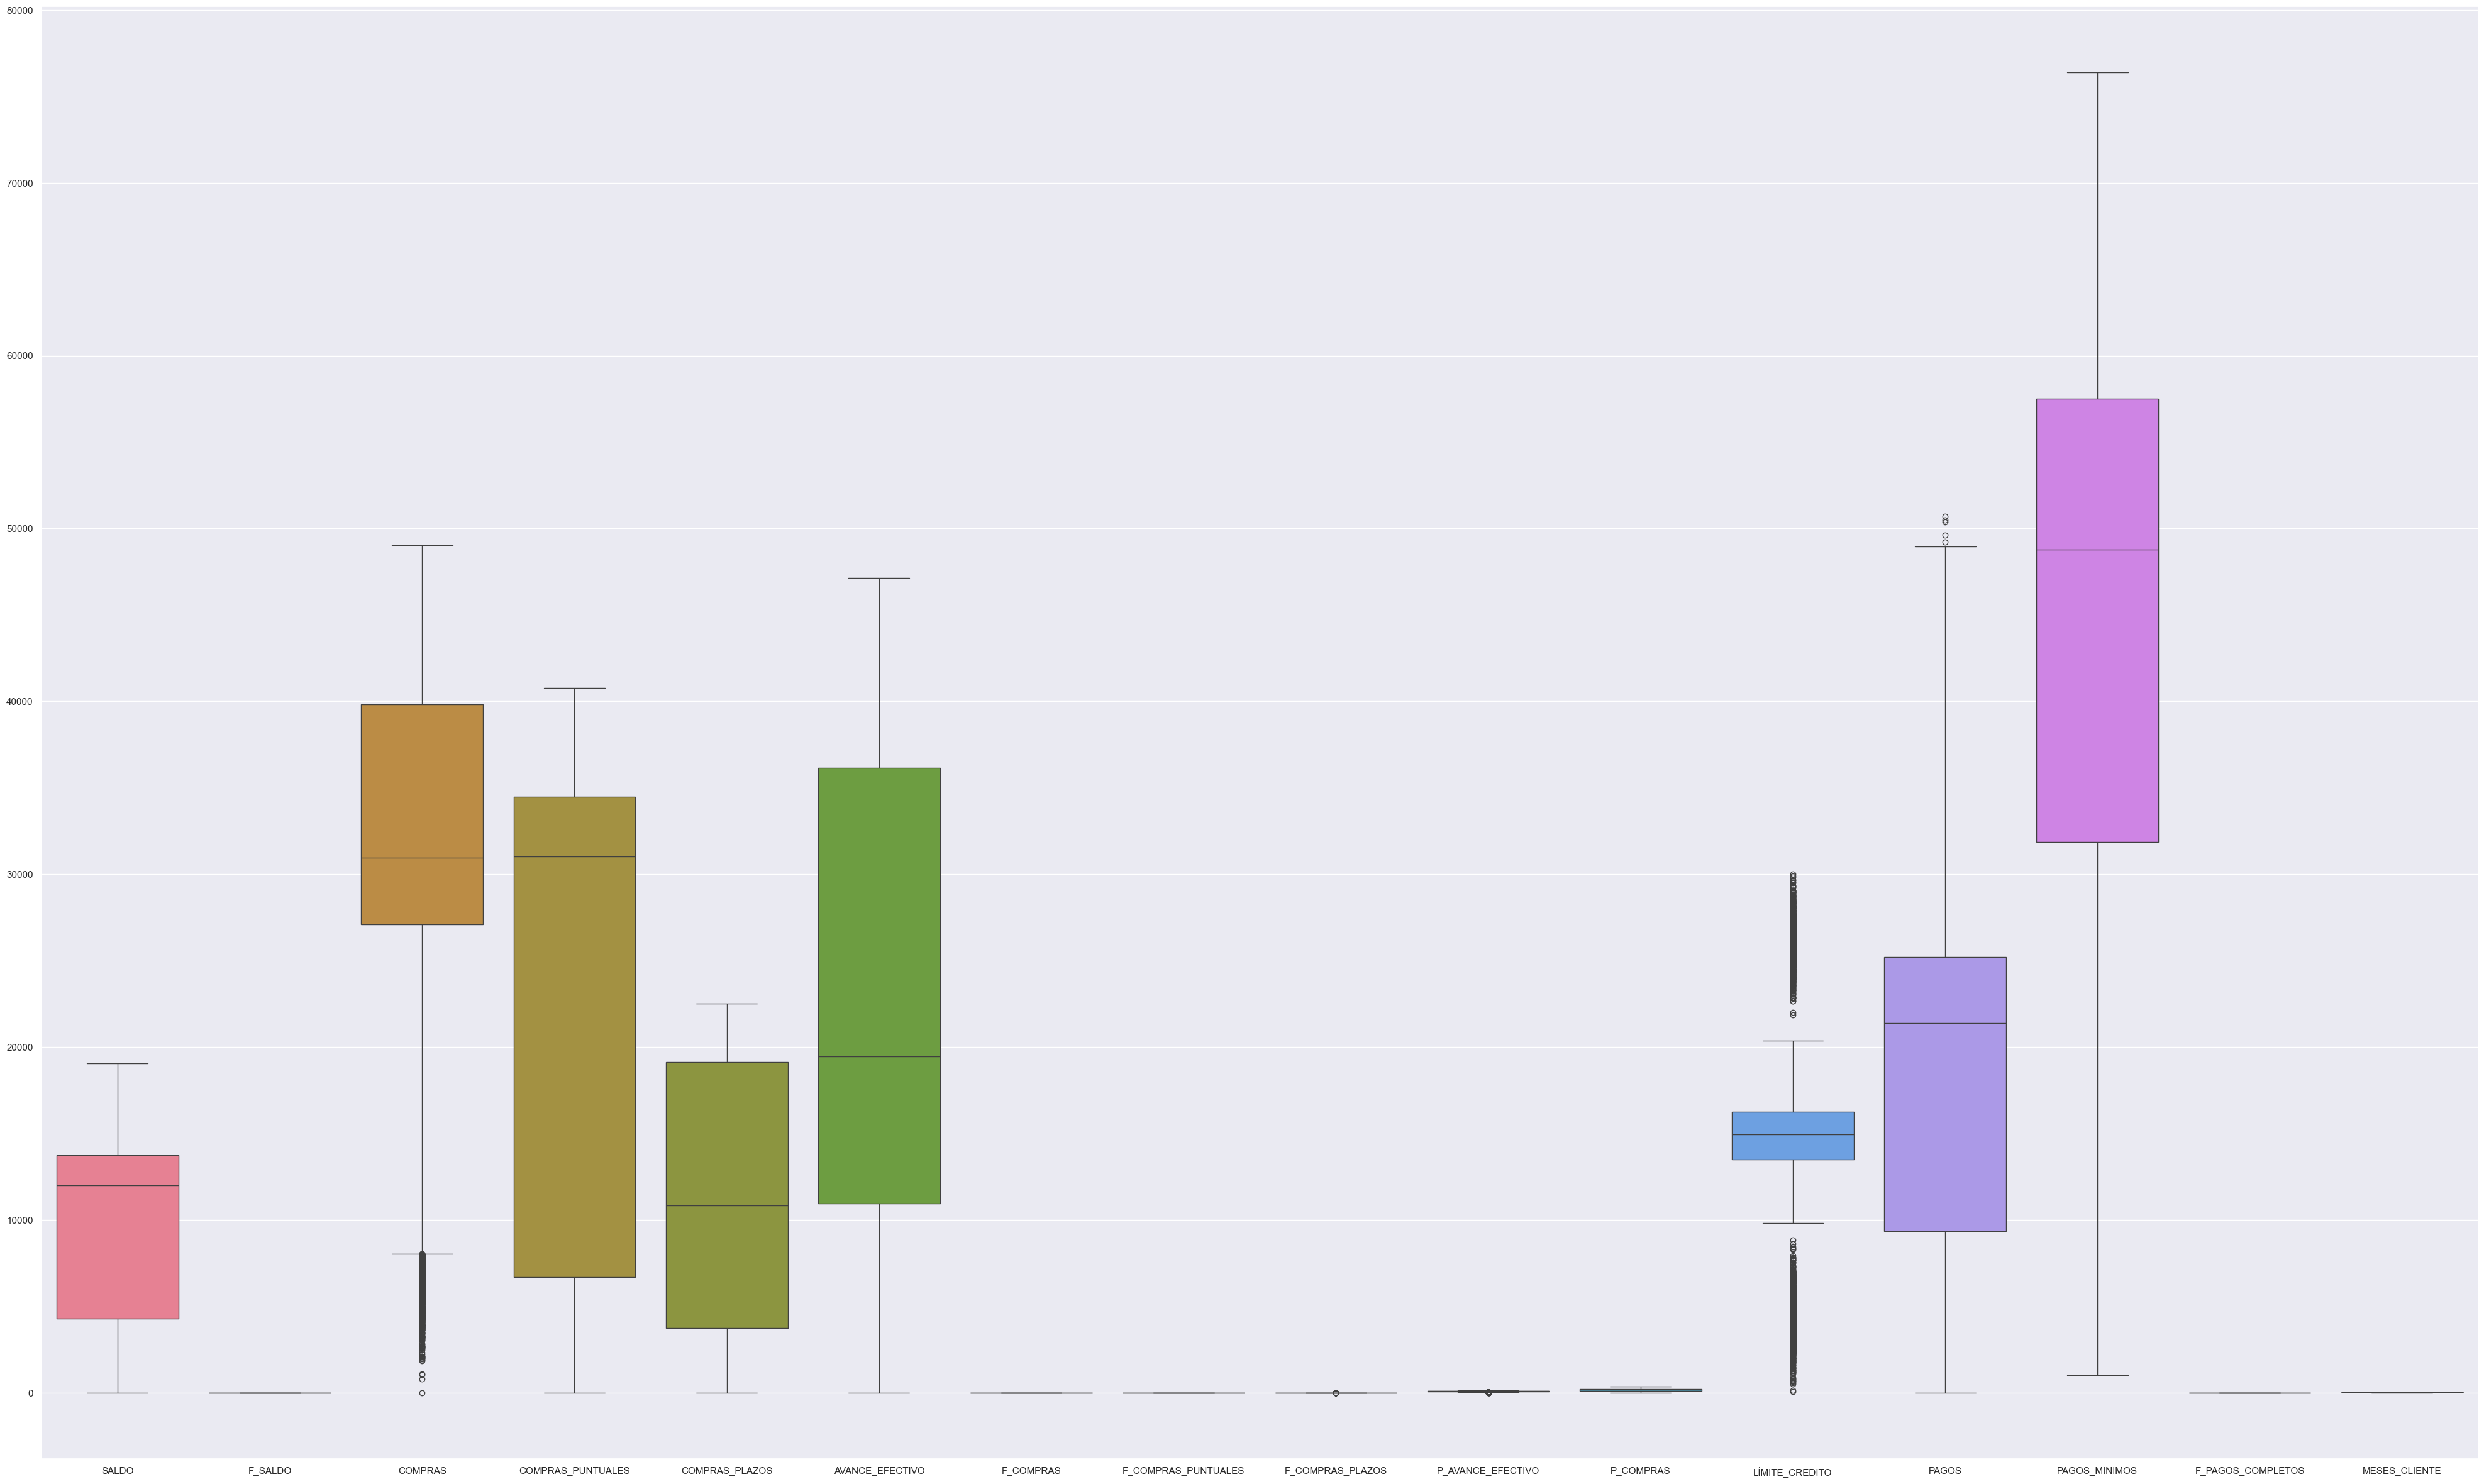

In [27]:
fig = plt.figure(figsize=(50, 30))
ax = sns.boxplot(data=finanzas, orient="v")
print(">> Se visualizan los datos en conjunto: ")
plt.show()

De los datos en conjunto se puede llegar a diferentes conclusiones. En primer lugar, se puede ver que COMPRAS, LÍMITE_CREDITO, PAGOS, PAGOS_MINIMOS y AVANCE_EFECTIVO tienen valores extremos, lo que en este contexto indica que hay clientes con patrones de consumo o uso de tarjeta de crédito muy diferentes. Para manejar los outliers se hace un limite inferior y superior a los sets de datos al percentil 5 y 95 respectivamente. Esta delimitación de valores se le hace a los atributos XXXXXXXX, porque son los que tienen más valores extremos y, por lo tanto, mayor probabilidad de sesgar el set de datos.

In [28]:
#REVISAR SI TODOS ESTOS

import numpy as np
finanzas["LÍMITE_CREDITO"] = np.log1p(finanzas["LÍMITE_CREDITO"])
finanzas["PAGOS"] = np.log1p(finanzas["PAGOS"])